### Hybrid Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Identify the frauds using SOM

In [2]:
df = pd.read_csv('Credit_Card_Applications.csv')

In [3]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

In [5]:
from minisom import MiniSom
som = MiniSom(x=10,y=10, input_len=15, sigma=1.0,learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X,num_iteration=100)

In [6]:
from pylab import bone, pcolor, colorbar, plot, show

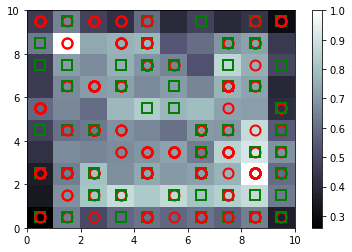

In [7]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o','s']
colors = ['r','g']
#i will be different indexs of each customer, x will be the row for each customer
for i, x in enumerate (X):
    w = som.winner(x) # For this winning node, place a marker and plot it
    plot(w[0]+0.5, w[1]+0.5,markers[y[i]],markeredgecolor = colors[y[i]],markerfacecolor = 'None',markersize = 10,markeredgewidth = 2) 
show()
# to put the parker at the center of the square of the winning node 
# red if customer did not get approved, green if they did

In [8]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(5,3)] , mappings[(6,4)]), axis=0) #0 is vertical, 1 is horizontal
frauds = sc.inverse_transform(frauds)

***We have the frauds, now we will go from unsupervised to supervised learning***

***We need to first come up with a dependent variable***

In [9]:
customers = df.iloc[:,1:].values

In [10]:
is_fraud = np.zeros(len(df))

In [12]:
for i in range(len(df)):
    if df.iloc[i,0] in frauds:  #i corresponds to the customer id
        is_fraud[i] = 1         #This will create the dependent variable

### ANN

In [14]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [53]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=2, activation='relu', input_dim=15))#input dim is columns
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"])
ann.fit(customers, is_fraud, batch_size = 1, epochs = 1) #32 is a typical value

690/690 [==============================] - 1s 729us/step - loss: 0.4766 - accuracy: 0.8522


***Lets predict the probability of frauds***

In [54]:
pred = ann.predict(customers)

22/22 [==============================] - 0s 710us/step


In [55]:
for i in range(5):
    print(pred[i])

[0.2077694]
[0.38604984]
[0.38604984]
[0.59734154]
[0.1385447]


In [56]:
pred = np.concatenate((df.iloc[:,0:1].values,pred), axis=1)

In [57]:
type(pred)

numpy.ndarray

***Lets now sort the customers and their probabilites to see which customers have the highets percentage of cheating***

In [58]:
pred = pred[pred[:,1].argsort()]

In [59]:
pred = pd.DataFrame(pred)

In [60]:
pred.head()

,0,1
0,15585855.0,0.000174
1,15725028.0,0.000242
2,15566495.0,0.000487
3,15654859.0,0.000487
4,15723827.0,0.000873


In [61]:
pred.columns = ["Customer_id","Probability"]

In [62]:
pred.head()

,Customer_id,Probability
0,15585855.0,0.000174
1,15725028.0,0.000242
2,15566495.0,0.000487
3,15654859.0,0.000487
4,15723827.0,0.000873


In [63]:
pred.tail()

,Customer_id,Probability
685,15772941.0,0.567289
686,15687688.0,0.597342
687,15572361.0,0.601644
688,15667588.0,0.615051
689,15621423.0,0.924355


***Looking at the tail of the dataset, we can see the customers with the highest probability of cheating, this would be reported sp further investigation could undergo***